In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
data = np.loadtxt('cluster.dat').T
mean = np.mean(data,axis=0).reshape(1,2)
std = np.std(data,axis=0).reshape(1,2)

max_iters = 5
num_clusters = 8

In [9]:
def dist(a,b):
    return np.sum((a-b)**2)

def error(centers, points):
    error = 0
    for p in points:
        error += dist(p[:2], centers[int(p[2])])
    error = error / (2*points.shape[0])
    return error

def initial_centers(num_clusters, seed):
    #returns initial cluster centers around the mean 
    #(by sampling from a uniform distribution 
    #centered around the mean and limited by half of the standard deviation)
    means = np.repeat(mean,num_clusters,axis=0)
    stds = np.repeat(std,num_clusters,axis=0)
    rand_multipliers = np.random.RandomState(seed).uniform(low=-1, high=1, size=[num_clusters,2])
    centers = means+(rand_multipliers*stds*0.5)
    return centers

def batch_iteration(centers, points):
    distances = np.zeros([centers.shape[0],1])
    for p in points: #assign the closest cluster center to each point
        for i, c in enumerate(centers): #calculate distance to each center
            distances[i] = dist(p[:2],c)
        p[2] = np.argmin(distances) 
        
    #calculate new position of each cluster center
    #each point contributes to x, y 
    centers = np.zeros([centers.shape[0], centers.shape[1]+1])
    for p in points: 
        c_index = int(p[2])
        centers[c_index,0] += p[0]
        centers[c_index,1] += p[1]
        centers[c_index,2] += 1.0
        
    for c in centers:
        if c[2] != 0:
            c[0] = c[0]/c[2]
            c[1] = c[1]/c[2]
    return centers[:,:2], points

def plot_iteration(centers, ax):
    ax.scatter(data[:,0],data[:,1])
    ax.scatter(centers[:,0],centers[:,1],color="red",s=60)
    
def plot_error(num_iterations, errors, ax):
    ax.plot(np.arange(num_iterations), errors)
    ax.scatter(np.arange(num_iterations), errors)
    ax.set_ylim([0,2])
    ax.set_xlim([0,num_iterations-1])
    ax.set_title("Error by iteration", fontsize=18)

def kmeans(num_clusters, num_iterations=5):
    seeds = [0,1,2]
    
    fig, ax = plt.subplots(num_iterations+1,len(seeds), figsize=[20,4*num_iterations])
    message = "Batch kMeans: {:>1} cluster centers, 3 different random initial positions"
    fig.suptitle(message.format(num_clusters), fontsize = 24)
    
    for j, seed in enumerate(seeds):
        #random initial cluster centers around the mean of the data
        centers = initial_centers(num_clusters, seed)
        
        #append a column of zeros to the original data. 
        #(it will hold the indices of a given point's current cluster)
        points = np.concatenate([data, np.zeros([data.shape[0],1])], axis=1)
        errors = np.zeros(num_iterations)   

        for i in np.arange(num_iterations):
            plot_iteration(centers, ax[i,j])
            errors[i] = error(centers, points)
            centers, points = batch_iteration(centers, points)
        plot_error(num_iterations, errors, ax[num_iterations,j])
        yield centers

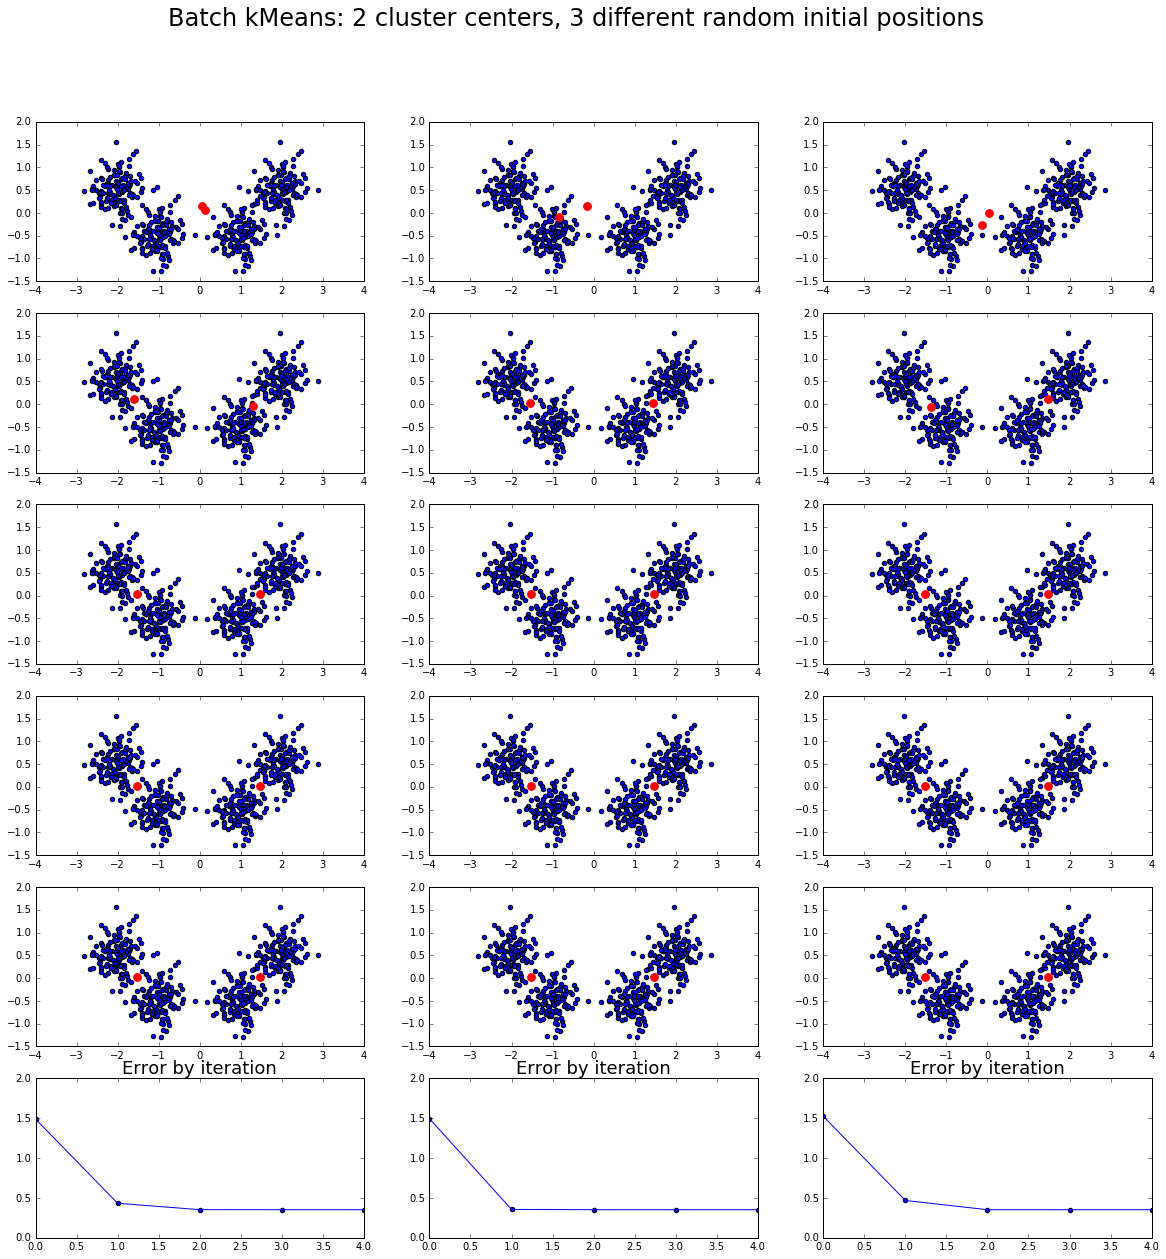

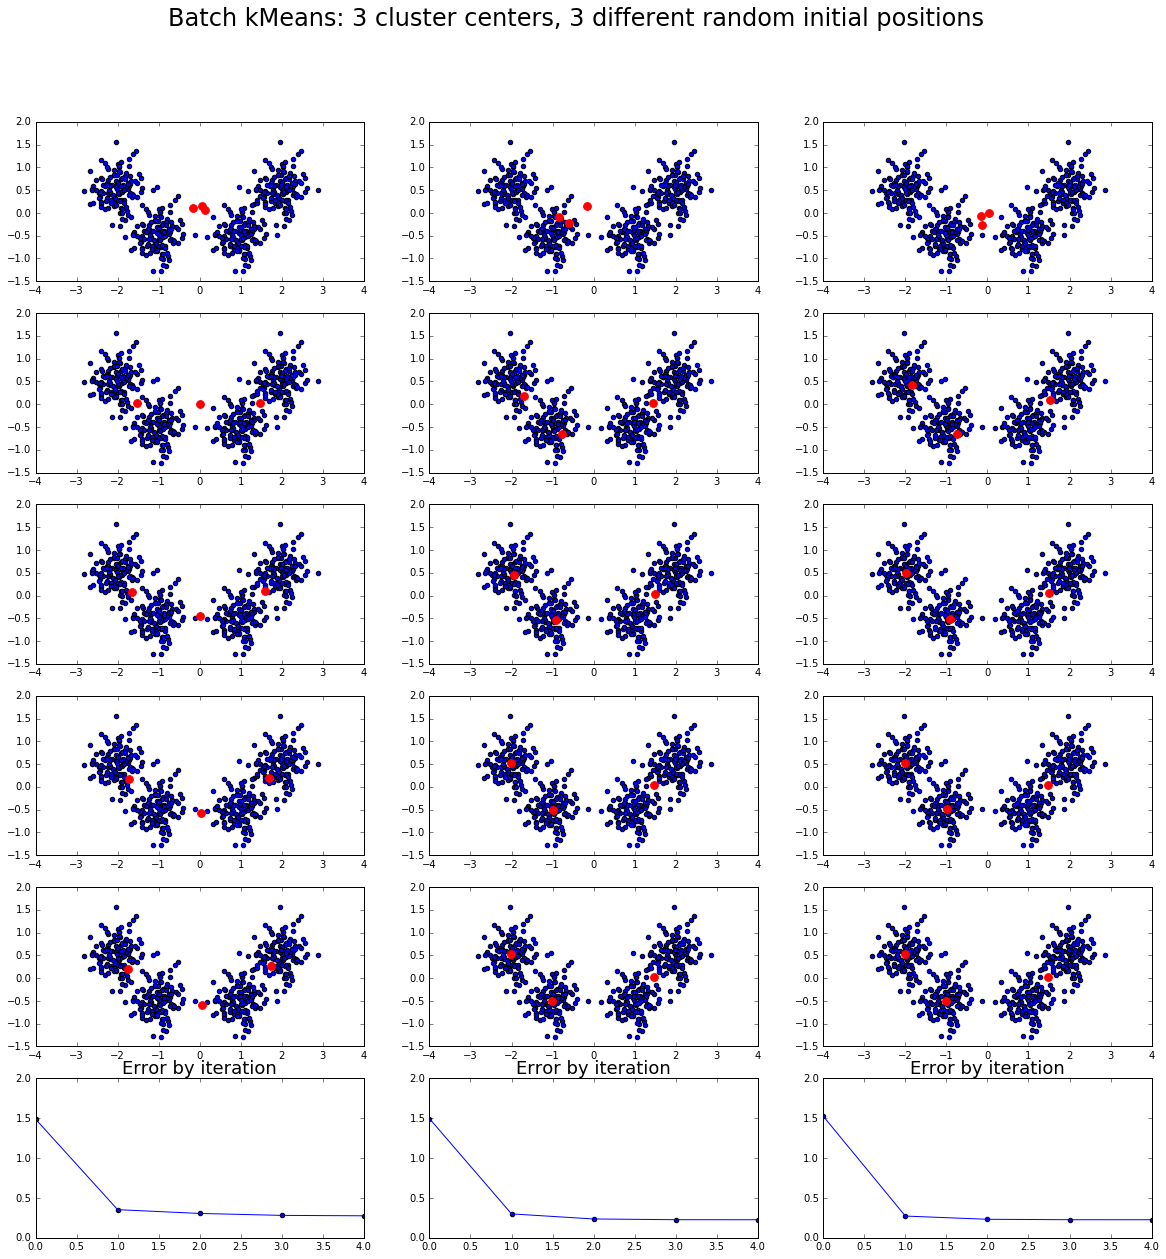

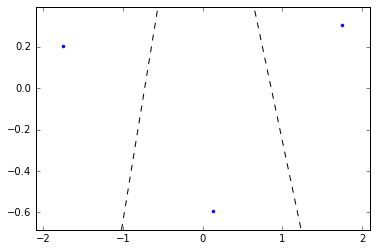

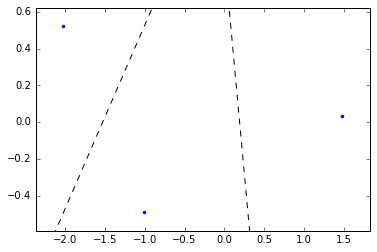

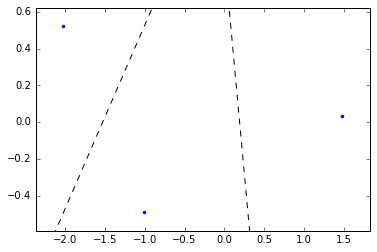

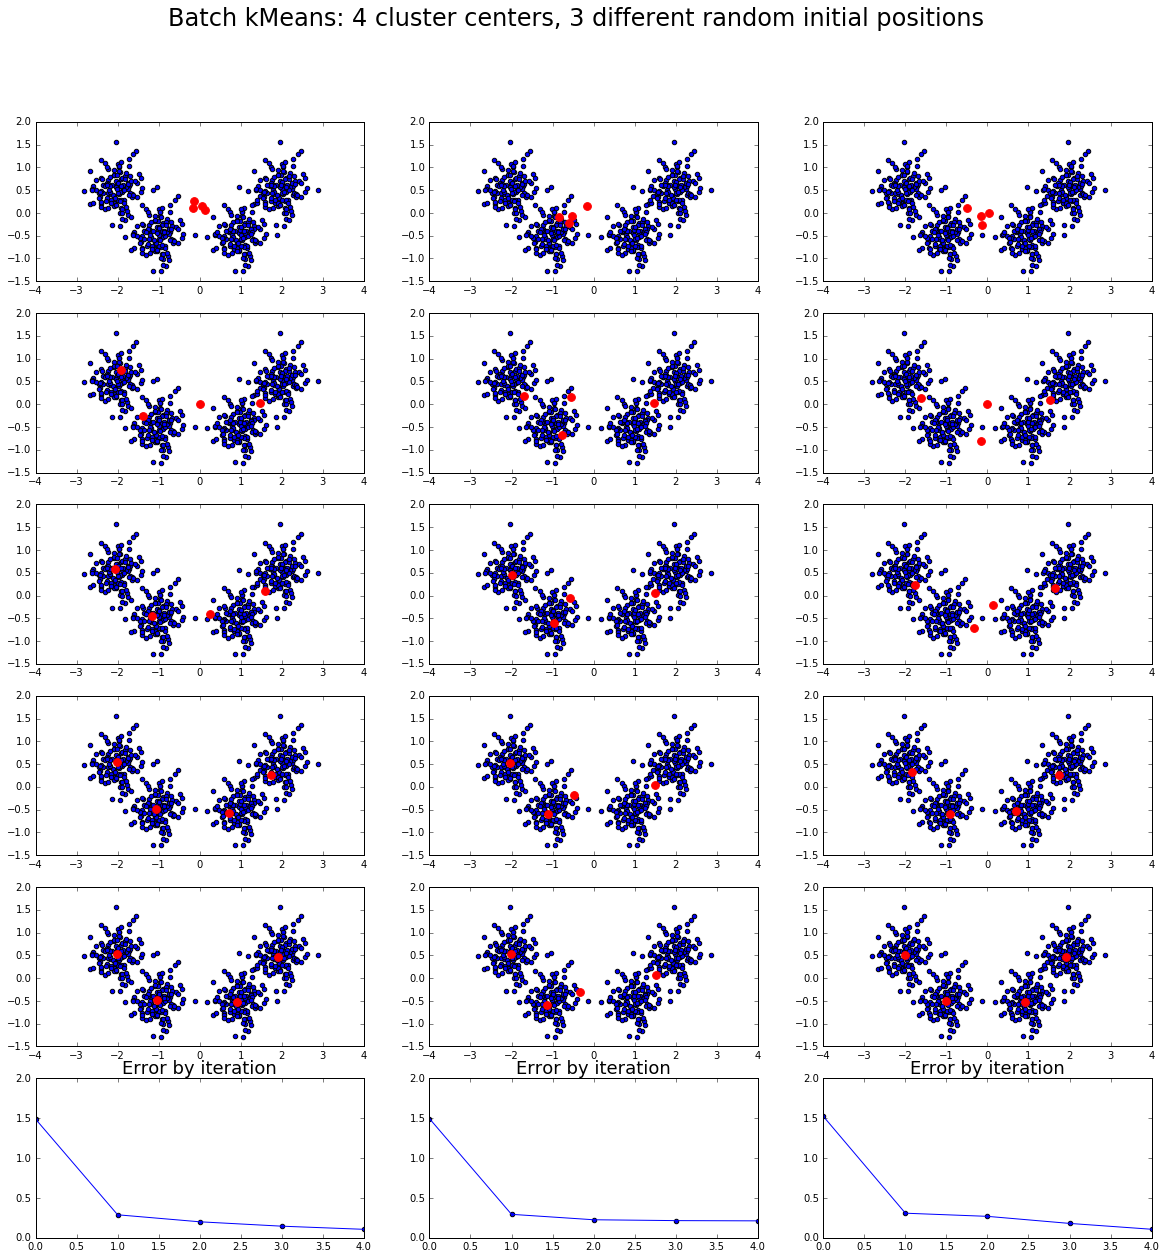

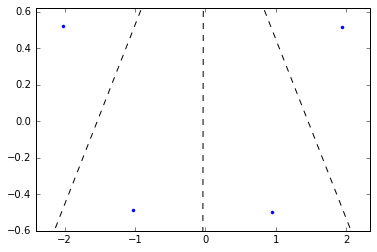

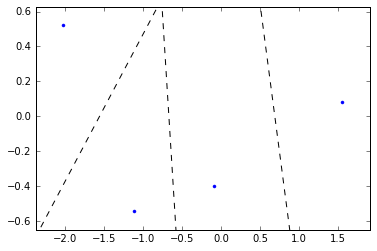

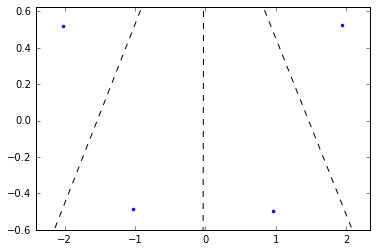

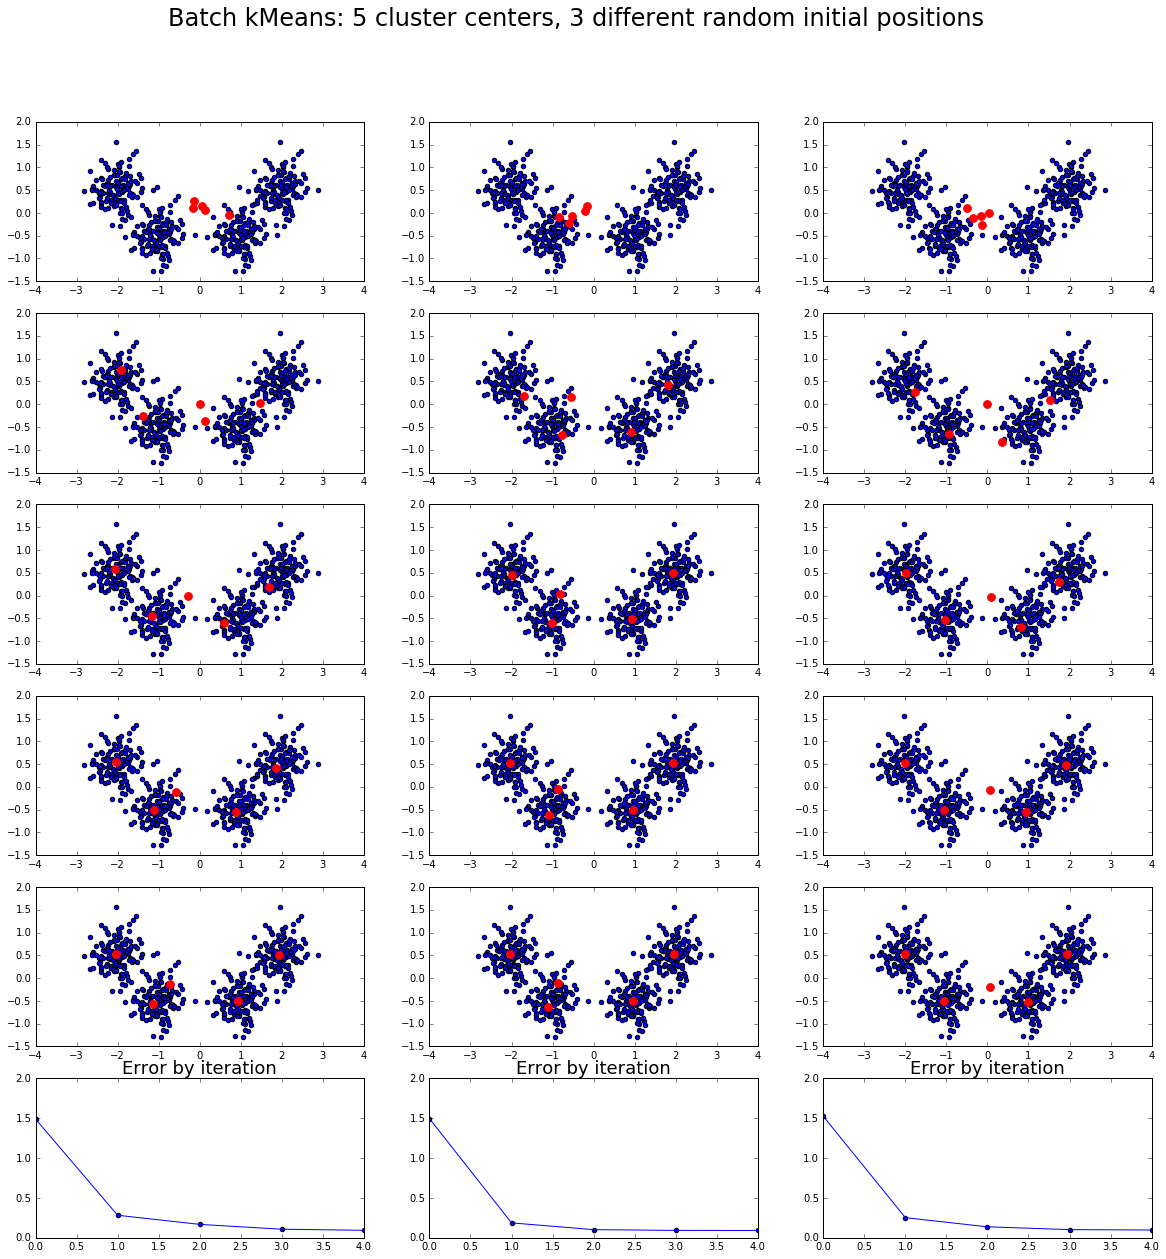

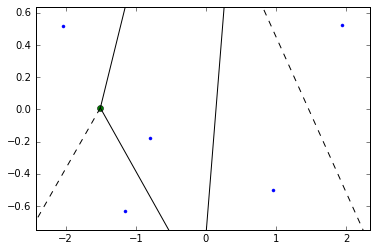

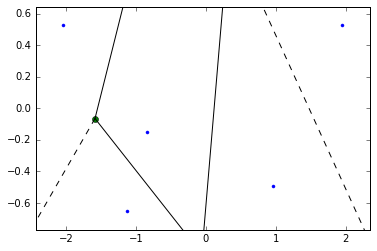

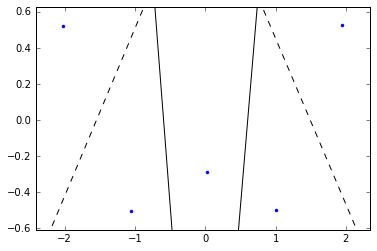

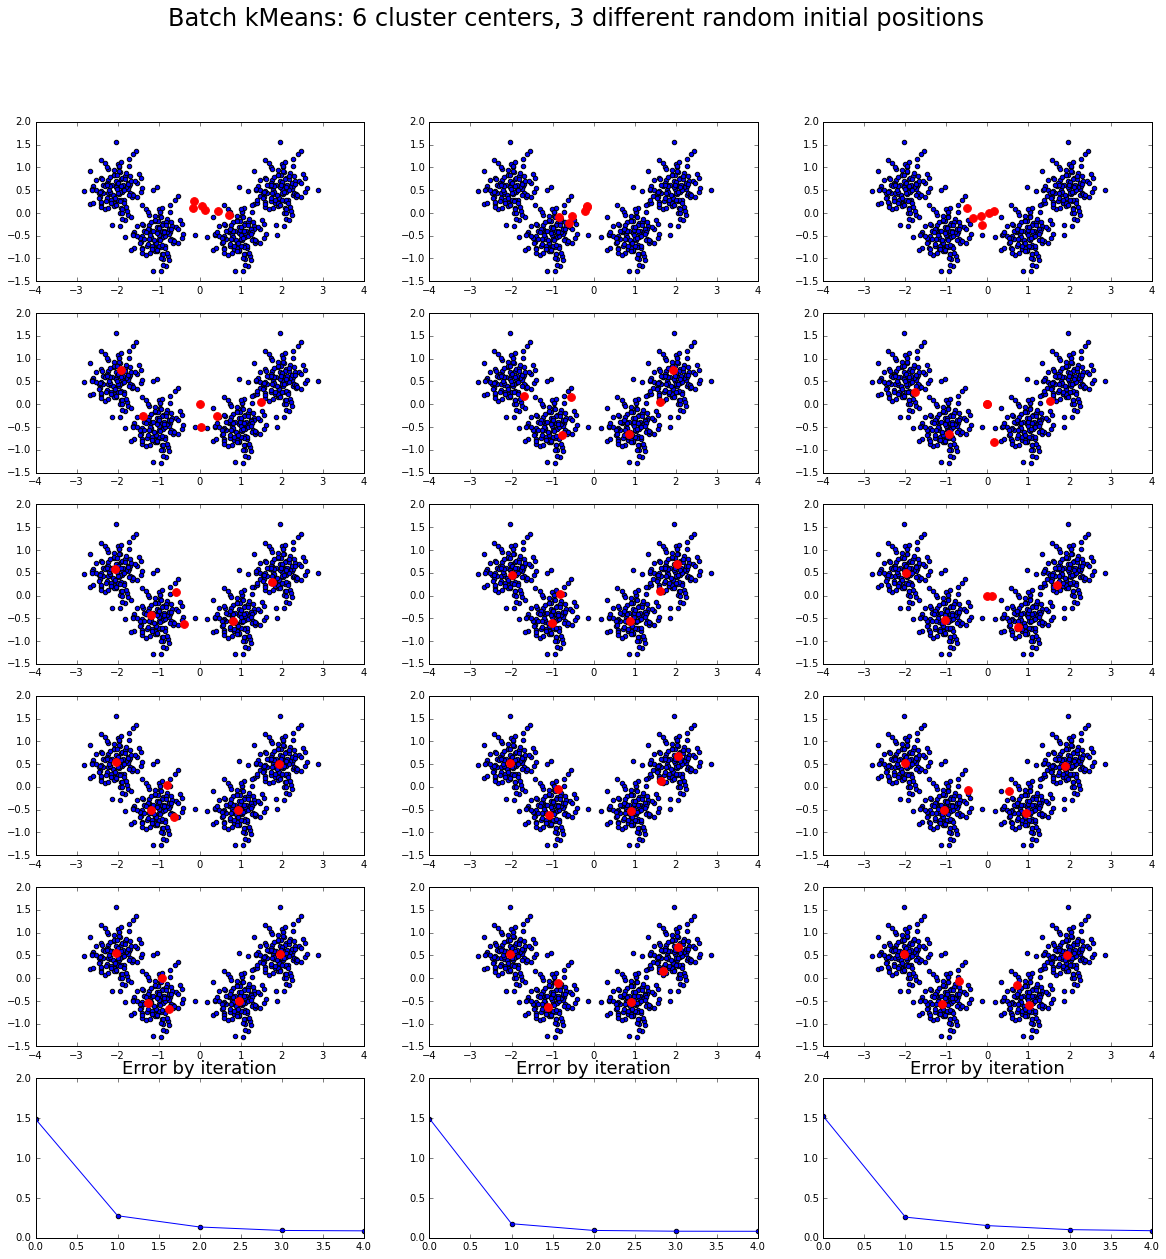

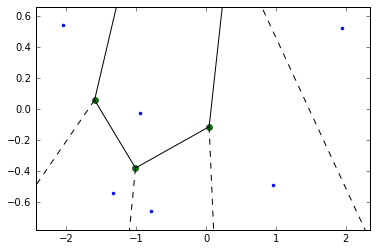

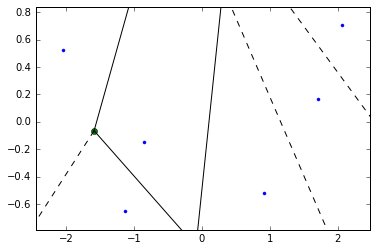

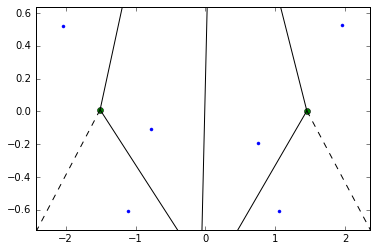

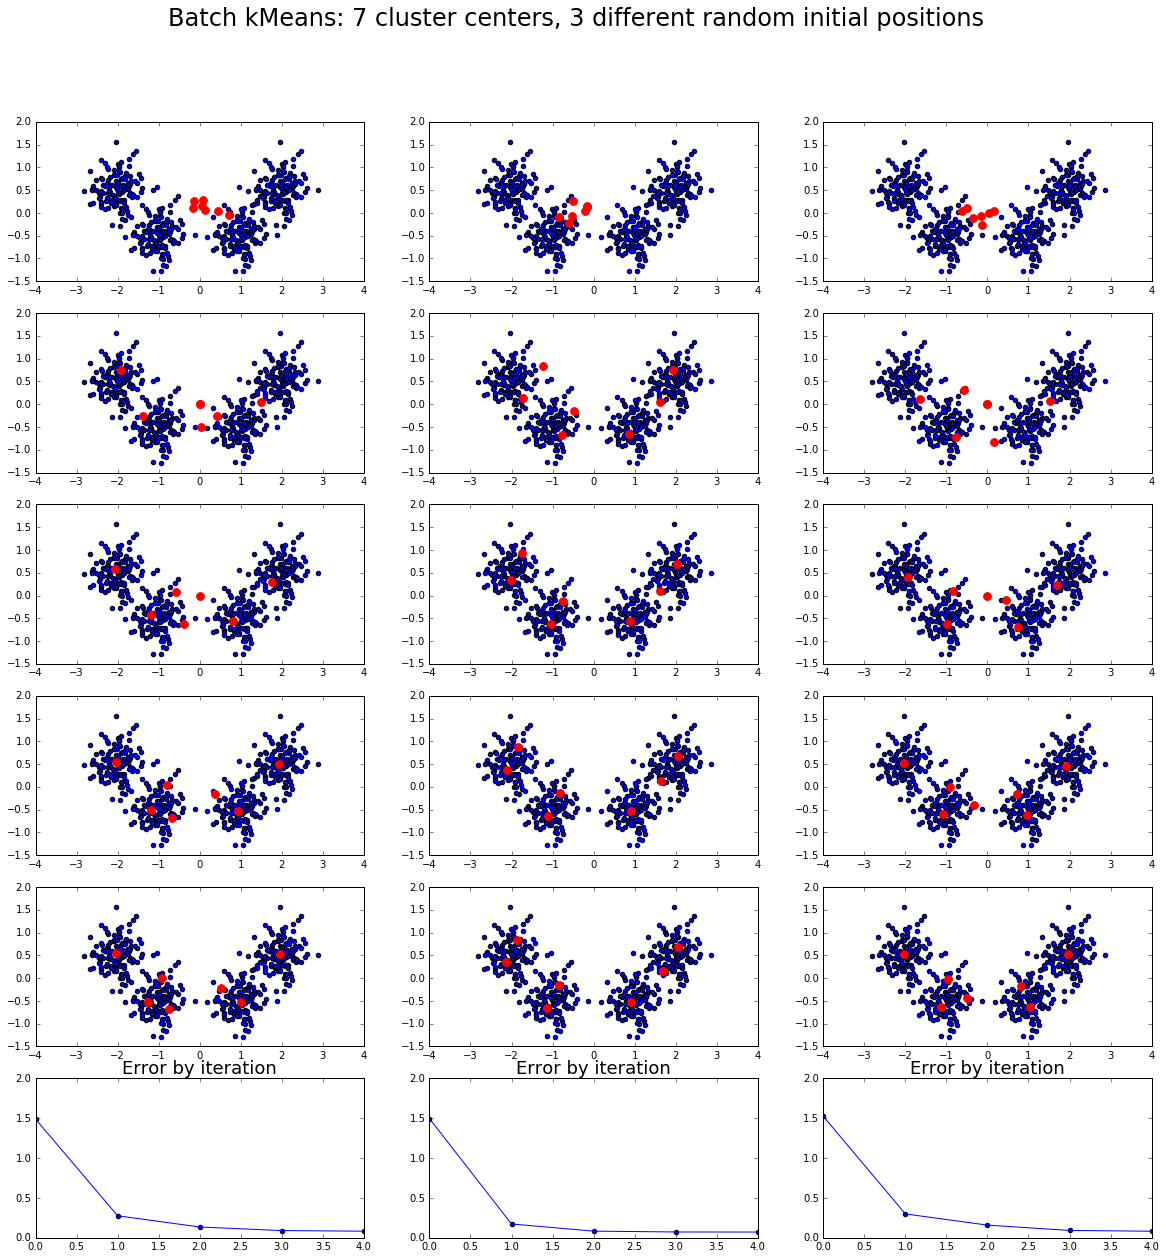

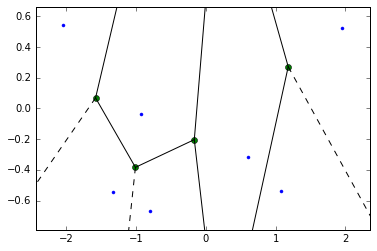

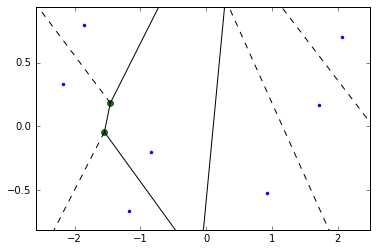

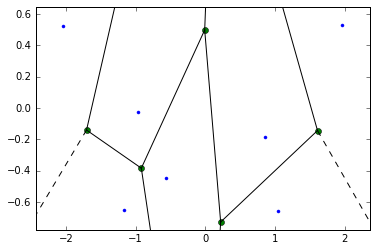

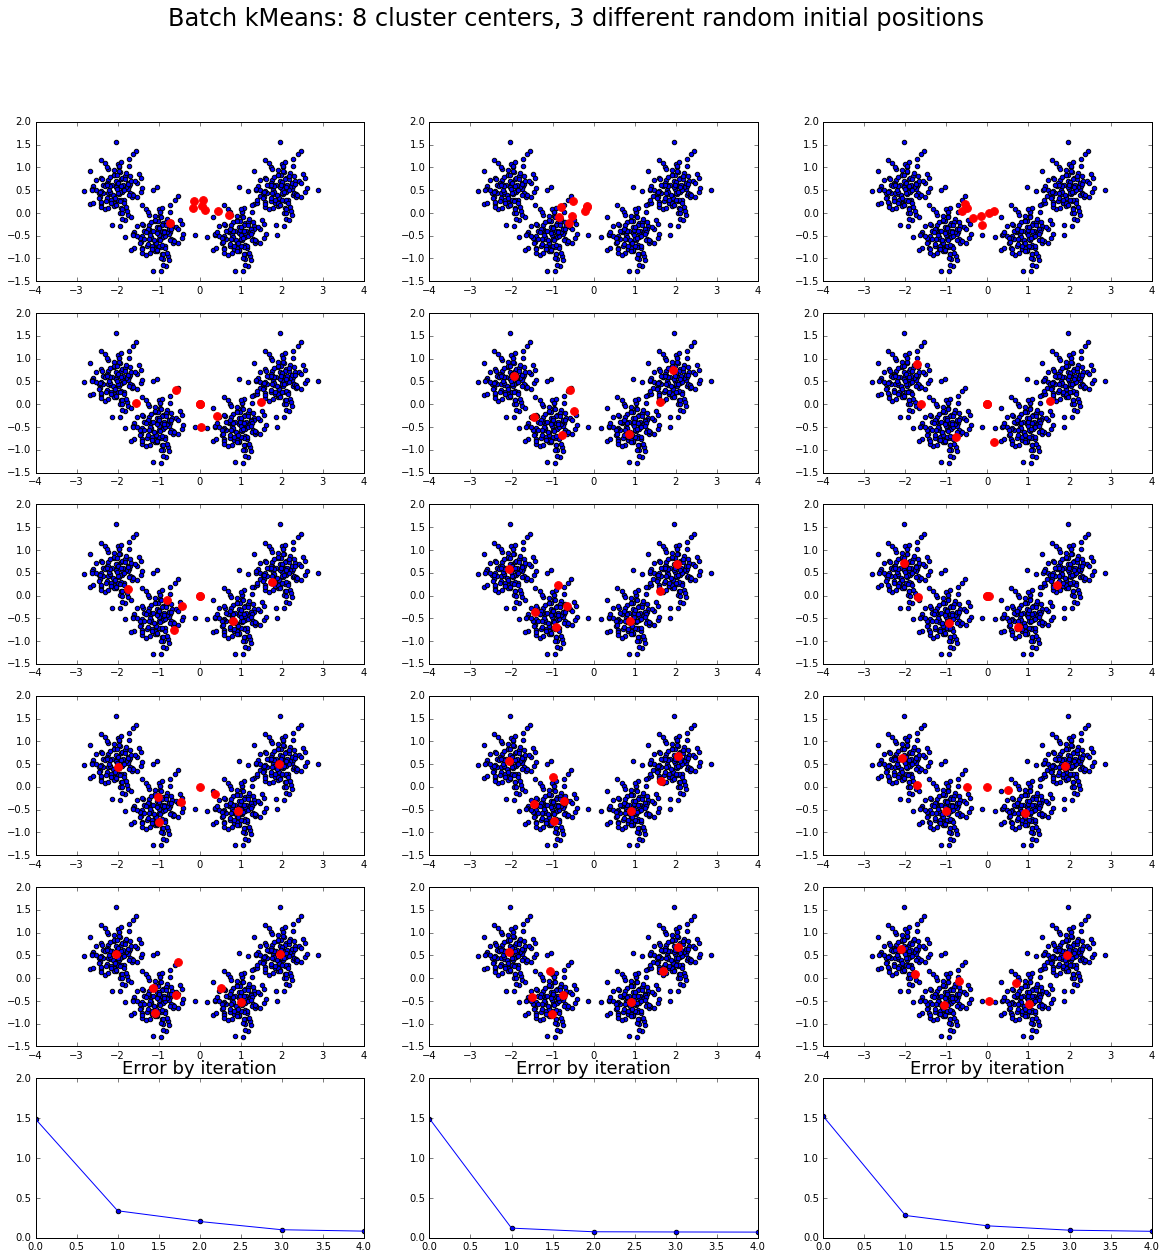

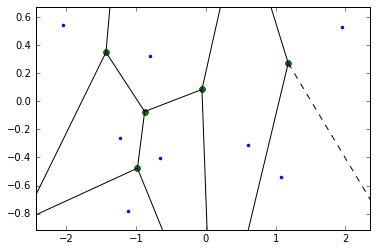

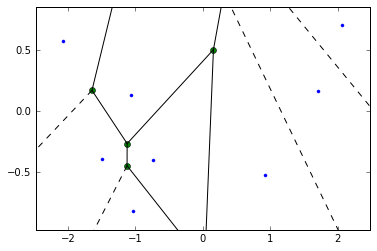

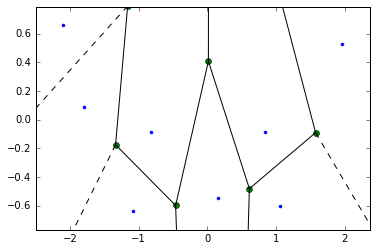

In [10]:
from scipy.spatial import Voronoi, voronoi_plot_2d

for k in [2,3,4,5,6,7,8]:
    centerss = list(kmeans(num_clusters=k))
    plt.show()
    for centers in centerss:
        try:
            voronoi_plot_2d(Voronoi(centers))
            plt.show()
        except:
            pass

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
data = np.loadtxt('cluster.dat').T

In [4]:
import sys
import functools


class Annealer:
    
    def __init__(self, initial=0.5, annealing=0.9):
        self._initial = initial
        self._annealing = annealing
    
    def __call__(self, iterations):
        learning_rate = self._initial
        for _ in range(iterations // 4):
            yield learning_rate
        while True:
            learning_rate *= self._annealing
            yield learning_rate


class OnlineKMeans:
    
    def __init__(self, k, seed=0):
        self._k = k
        self._random = np.random.RandomState(seed)

    def __call__(self, data, iterations, annealer):
        centers = self._init_centers(data)
        learning_rates = annealer(iterations)
        for time_step in range(iterations):
            point = data[self._random.choice(len(data))]
            assignment, distance = self._assignment(centers, point)
            offset = point - centers[assignment]
            centers[assignment] += next(learning_rates) * offset
            yield centers.copy()
    
    def _init_centers(self, data, distance=0.5):
        mean, cov = data.mean(axis=0), distance * np.cov(data.T).T
        centers = self._random.multivariate_normal(mean, cov, (self._k))
        return centers

    @classmethod
    def _assignment(cls, centers, point):
        distances = cls._distance(centers, point)
        assignment = np.argmin(distances)
        distance = distances[assignment]
        return assignment, distance

    @staticmethod
    def _distance(centers, point):
        offset = centers - point.reshape(1, -1)
        return (np.abs(offset)).sum(axis=1)
    

def error(centers, points):
    points = points.T
    error = 0
    for p in points:
        error += np.sum((p[:2] - centers[int(p[2])]) ** 2)
    error = error / (2 * points.shape[0])
    return error


def plot_clusters(centers, data, iterations):
    title = 'Clusters after {} iterations'.format(iterations)
    print(title)
    assignments = [OnlineKMeans._assignment(centers, x)[0] for x in data]
    fig, ax = plt.subplots()
    # fig.suptitle(title, fontsize=12)
    colors = np.arange(len(centers))
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], c=colors[assignments])
    ax.scatter(centers[:, 0], centers[:, 1], c=colors, s=200)
    fig.tight_layout()
    return ax

Clusters after 0 iterations


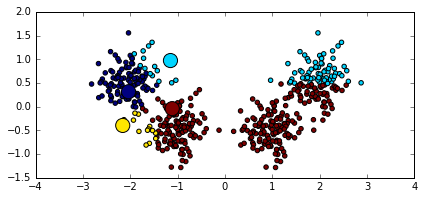

Clusters after 125 iterations


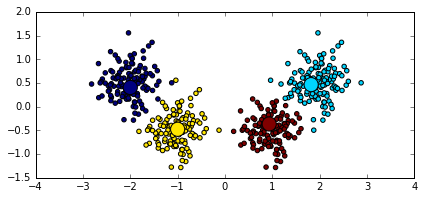

Clusters after 250 iterations


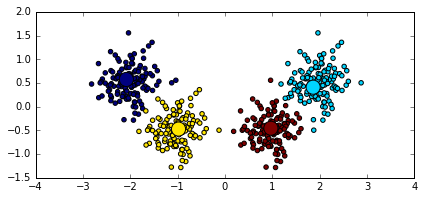

Clusters after 375 iterations


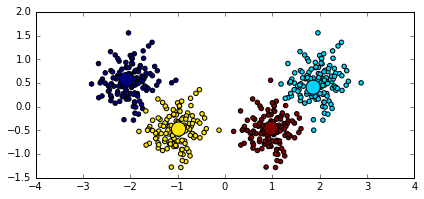

Clusters after 500 iterations


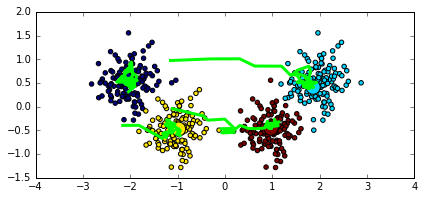

Error over number of iterations


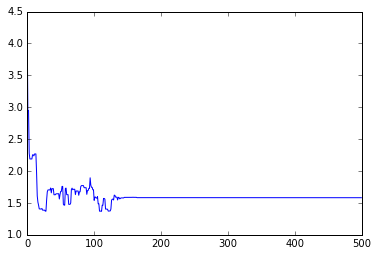

In [5]:
iterations = len(data)
annealer = Annealer(0.3, 0.9)
clustering = OnlineKMeans(4)(data, iterations, annealer)
all_centers = np.empty((iterations, 4, 2))
for index, centers in enumerate(clustering):
    if index % (iterations // 4) == 0:
        plot_clusters(centers, data, index)
        plt.show()
    all_centers[index] = centers
all_centers = np.array(all_centers)
    
ax = plot_clusters(centers, data, iterations)
for center in range(all_centers.shape[1]):
    ax.plot(all_centers[:, center, 0], all_centers[:, center, 1], c='lime', lw=3)
plt.show()

print('Error over number of iterations')
errors = np.array([error(centers, data) for centers in all_centers])
fig, ax = plt.subplots()
ax.plot(np.arange(iterations), errors)
plt.show()